In [30]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dcfd2420-e625-53cb-a630-a7cd21b73310)


In [31]:
!pip install -q flax

In [32]:
import os
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.nn.initializers import normal as normal_init

from flax import linen as nn
from flax.training import train_state, checkpoints

import numpy as np
import optax

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

from typing import Any

from PIL import Image

# PyTorch
import torch
import torchvision

In [33]:
jax.default_backend()

'gpu'

Load Data

In [34]:
def set_range(batch):
  batch = tf.image.convert_image_dtype(batch['image'], tf.float32)
  batch = (batch - 0.5) / 0.5  # tanh range is -1, 1
  return batch
 
batch_size = 256

mnist_train_data = tfds.load("mnist")['train']
mnist_test_data = tfds.load("mnist")['test']
batches_in_train_epoch = len(mnist_train_data) // batch_size
batches_in_test_epoch = len(mnist_test_data) // batch_size
 
train_data_gen = iter(tfds.as_numpy(
      mnist_train_data
        .map(set_range)
        .cache()
        .shuffle(len(mnist_train_data), seed=41)
        .repeat()
        .batch(batch_size)
 ))
test_data_gen = iter(tfds.as_numpy(
      mnist_test_data
        .map(set_range)
        .cache()
        .shuffle(len(mnist_test_data), seed=41)
        .repeat()
        .batch(batch_size)
 ))


In [35]:
def get_dataloaders():
  return train_data_gen, test_data_gen

In [36]:
CHECKPOINT_PATH = "./saved_models/mnist_gan"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [37]:
class Discriminator(nn.Module):
  features: int = 64
  training: bool = True

  q_cat: int = 10

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(self.features, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Conv(self.features*2, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    
    # Discriminator output
    d = nn.Conv(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    d = d.reshape((d.shape[0], -1))

    # Q outpiut
    q = nn.Conv(self.features*2, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    q = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(q)
    q = nn.leaky_relu(q, 0.2)
    q = nn.Conv(self.q_cat, [1, 1], [2, 2], 'VALID', kernel_init=normal_init(0.02))(q)
    q = q.reshape((q.shape[0], -1))
    
    # print(jnp.shape(d), jnp.shape(q))
    
    return d, q


In [38]:
class Generator(nn.Module):
  features: int = 64
  training: bool = True

  @nn.compact
  def __call__(self, z):
    # print(z)
    z = z.reshape((z.shape[0], 1, 1, z.shape[1]))
    x = nn.ConvTranspose(self.features*4, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(z)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features*2, [4, 4], [1, 1], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = jnp.tanh(x)

    # print(jnp.shape(x))
    return x

Saving and loading the model from disk

In [39]:
def save_model(discrim_state, gen_state, step=0):
  checkpoints.save_checkpoint(ckpt_dir=CHECKPOINT_PATH,
                              target={'discrim_params': discrim_state.params,
                                      'gen_params': gen_state.params,
                                      'discrim_batch_stats': discrim_state.batch_stats,
                                      'gen_batch_stats': gen_state.batch_stats},
                              step=step,
                              overwrite=True)
  

In [40]:
def load_model():
  state_dict = checkpoints.restore_checkpoint(ckpt_dir=CHECKPOINT_PATH, target=None)
  return state_dict["discrim_params"], state_dict["discrim_batch_stats"], state_dict["gen_params"], state_dict["gen_batch_stats"]

In [41]:
def checkpoint_exists():
  return checkpoints.latest_checkpoint(ckpt_dir=CHECKPOINT_PATH) != None

def checkpoint_epoch():
  if checkpoint_exists():
    return int(checkpoints.latest_checkpoint(ckpt_dir=CHECKPOINT_PATH).split("_")[-1])
  return -1

Generating inputs to the generator and fake images from the generator

In [42]:
def generate_latent_points(rng, latent_dim, n_samples):
  rng, latent_rng, cat_rng = jrandom.split(rng, num=3)
  latent_inputs = jrandom.normal(latent_rng, (n_samples, latent_dim))
  cat_codes = jrandom.randint(cat_rng, (n_samples,), 0, 10)
  cat_codes = nn.one_hot(cat_codes, 10)
  z_input = jnp.concatenate((latent_inputs, cat_codes), axis=1)

  return z_input, cat_codes

In [43]:
def generate_latent_fixed_points(rng, latent_dim, value, n_samples):
  rng, latent_rng, cat_rng = jrandom.split(rng, num=3)
  latent_inputs = jrandom.normal(latent_rng, (n_samples, latent_dim))
  cat_codes = jnp.full((n_samples,), value)
  cat_codes = nn.one_hot(cat_codes, 10)
  z_input = jnp.concatenate((latent_inputs, cat_codes), axis=1)

  return z_input, cat_codes

In [44]:
def create_fake_imgs(rng, num, gen_state, latent_dim):
  rng, latent_rng = jrandom.split(rng)
  z_input, _ = generate_latent_points(latent_rng, latent_dim, num)
  fake_imgs, _ = Generator().apply({"params": gen_state.params, "batch_stats": gen_state.batch_stats},
                                  z_input,
                                  mutable=["batch_stats"])
  return fake_imgs

In [45]:
def create_fixed_fake_imgs(rng, num, gen_state, latent_dim, value):
  rng, latent_rng = jrandom.split(rng)
  z_input, _ = generate_latent_fixed_points(latent_rng, latent_dim, value, num)
  fake_imgs, _ = Generator().apply({"params": gen_state.params, "batch_stats": gen_state.batch_stats},
                                  z_input,
                                  mutable=["batch_stats"])
  return fake_imgs

In [46]:
class TrainState(train_state.TrainState):
    # A simple extension of TrainState to also include batch statistics
    batch_stats: Any

In [47]:
def create_train_discrim_state(rng, image_shape, learning_rate):
  rng, init_rng, dropout_rng = jrandom.split(rng, 3)

  discrim = Discriminator().init(init_rng, jnp.ones(image_shape, jnp.float32))
  params = discrim['params']
  batch_stats = discrim['batch_stats']
  tx = optax.adam(learning_rate, 0.5, 0.999)

  if checkpoint_exists():
    params, batch_stats, _, _ = load_model()

  return TrainState.create(
      apply_fn = Discriminator().apply,
      params = params,
      tx = tx,
      batch_stats = batch_stats
  )

In [48]:
def create_train_gen_state(rng, latent_shape, learning_rate):
  rng, latent_rng = jrandom.split(rng)

  gen = Generator().init(rng, jnp.ones(latent_shape, jnp.float32))
  params = gen["params"]
  batch_stats = gen["batch_stats"]
  tx = optax.adam(learning_rate, 0.5, 0.999)

  if checkpoint_exists():
    _, _, params, batch_stats = load_model()

  return TrainState.create(
      apply_fn = Generator().apply,
      params = params,
      batch_stats = batch_stats,
      tx = tx
  )

In [49]:
@jax.jit
def mean_square_error_loss(logits, labels):
  # neg_abs = -jnp.abs(logits)
  # batch_bce = jnp.maximum(logits, 0) - logits * labels + jnp.log(1 + jnp.exp(neg_abs))
  # batch_bce = jnp.mean(batch_bce)

  batch_mse = jnp.mean(jnp.square(logits-labels))

  return batch_mse

In [50]:
@jax.jit
def mutual_information_loss(code_cat, q_cat):
  cat_loss = jnp.mean(jnp.sum(code_cat * q_cat, axis=-1))
  mi_loss = -cat_loss
  return mi_loss

In [51]:
@jax.jit
def compute_metrics(logits, labels):
  loss = mean_square_error_loss(logits, labels)

  logits = nn.sigmoid(logits-0.5)
  accuracy = jnp.mean(jnp.round(logits) == labels)

  return {
      'loss': loss,
      'accuracy': accuracy,
  }


Real = 1, Fake = 0

In [52]:
@jax.jit
def train_discrim_step(rng, discrim_state, real_imgs, fake_imgs, fake_cat_input):
  real_labels = jnp.ones(jnp.shape(real_imgs)[0], dtype=jnp.int32)
  fake_labels = jnp.zeros(jnp.shape(fake_imgs)[0], dtype=jnp.int32)

  # Train for a single step
  def discrim_loss_fn(d_params):
    (y_hat_real, _), d_vars = Discriminator().apply({"params": d_params, "batch_stats": discrim_state.batch_stats}, 
                                    real_imgs,
                                    mutable=['batch_stats'])
    y_hat_real = jnp.reshape(y_hat_real, (jnp.shape(y_hat_real)[0],))
    real_loss = mean_square_error_loss(y_hat_real, real_labels)

    (y_hat_fake, cat_hat_fake), d_vars = Discriminator().apply({"params": d_params, "batch_stats": d_vars["batch_stats"]}, 
                                    fake_imgs,
                                    mutable=['batch_stats'])
    y_hat_fake = jnp.reshape(y_hat_fake, (jnp.shape(y_hat_fake)[0],))
    fake_loss = mean_square_error_loss(y_hat_fake, fake_labels)

    q_cat_fake = nn.log_softmax(cat_hat_fake, axis=-1)

    loss_mi = mutual_information_loss(fake_cat_input, q_cat_fake)
    img_loss = ((real_loss + fake_loss) / 2)

    return img_loss + 1.05*loss_mi, (y_hat_real, y_hat_fake, d_vars)
  
  grad_fn = jax.value_and_grad(discrim_loss_fn, has_aux=True)
  (loss, (real_logits, fake_logits, d_vars)), grads = grad_fn(discrim_state.params)
  discrim_state = discrim_state.apply_gradients(grads=grads, batch_stats=d_vars["batch_stats"])

  all_logits = jnp.append(real_logits, fake_logits, axis=0)
  all_labels = jnp.append(real_labels, fake_labels)
  metrics = compute_metrics(logits = all_logits, labels = all_labels)

  return discrim_state, metrics

In [53]:
@jax.jit
def train_gen_step(rng, discrim_state, gen_state, latent_inputs, fake_cat_input):
  
  # Wrong labels (labeling fake as 1 instead of 0)
  wrong_fake_labels = jnp.ones(jnp.shape(latent_inputs)[0])
  
  # We want generator to maximize loss, meaning if Discriminator spits out a lot of 1's the loss should be low
  def gen_loss_fn(g_params):
    fake_imgs, g_vars = Generator().apply({"params": g_params, "batch_stats": gen_state.batch_stats},
                                latent_inputs,
                                mutable=['batch_stats'])
    
    (y_hat, cat_hat), d_vars = Discriminator().apply({"params": discrim_state.params, "batch_stats": discrim_state.batch_stats},
                                  fake_imgs,
                                  mutable=['batch_stats'])
    y_hat = jnp.reshape(y_hat, (jnp.shape(y_hat)[0],))
    img_loss = mean_square_error_loss(y_hat, wrong_fake_labels)

    q_cat = nn.log_softmax(cat_hat, axis=-1)
    loss_mi = mutual_information_loss(fake_cat_input, q_cat)

    return img_loss + 1.05*loss_mi, (y_hat, fake_imgs, d_vars, g_vars)
  
  grad_fn = jax.value_and_grad(gen_loss_fn, has_aux=True)
  (loss, (all_logits, fake_imgs, d_vars, g_vars)), grads = grad_fn(gen_state.params)
  gen_state = gen_state.apply_gradients(grads=grads, batch_stats=g_vars["batch_stats"])

  discrim_state = discrim_state.replace(batch_stats = d_vars["batch_stats"])

  metrics = compute_metrics(logits = all_logits, labels = wrong_fake_labels)

  return gen_state, discrim_state, fake_imgs, metrics

In [54]:
@jax.jit
def eval_step(rng, discrim_state, gen_state, all_imgs, all_labels):
  rng, dropout_rng = jrandom.split(rng)

  (y_hat, _), _ = Discriminator().apply({"params": discrim_state.params, "batch_stats": discrim_state.batch_stats}, 
                                    all_imgs,
                                    mutable=["batch_stats"])
  y_hat = jnp.reshape(y_hat, (jnp.shape(y_hat)[0],))
  return compute_metrics(y_hat, all_labels)


In [55]:
def eval_model(rng, discrim_state, gen_state, latent_dim, test_loader):
  losses, accuracies = [], []


  for batch_idx in range(batches_in_test_epoch):
    batch = next(test_loader)

    real_labels = jnp.ones(len(batch))
    fake_labels = jnp.zeros(len(batch))
    all_labels = jnp.append(real_labels, fake_labels)
    
    # Generate fake images
    rng, test_rng, latent_rng = jrandom.split(rng, num = 3)
    fake_imgs = create_fake_imgs(latent_rng, len(batch), gen_state, latent_dim)
    all_imgs = jnp.append(batch, fake_imgs, axis=0)

    metrics = eval_step(test_rng, discrim_state, gen_state, all_imgs, all_labels)
    metrics = jax.device_get(metrics)
    summary = jax.tree_util.tree_map(lambda x: x.item(), metrics)
    losses.append(summary['loss']), accuracies.append(summary['accuracy'])
  
  return jnp.mean(jnp.array(losses)), jnp.mean(jnp.array(accuracies))

In [56]:
def train_epoch(rng, discrim_state, gen_state, latent_dim, train_loader, epoch):

  # Train for a single epoch
  for batch_idx in range(batches_in_train_epoch):
    batch = next(train_loader)

    # Generate fake images
    rng, latent_rng, gen_rng, train_rng, eval_rng = jrandom.split(rng, num = 5)
    z_input, cat_onehot = generate_latent_points(latent_rng, latent_dim, len(batch))
    gen_state, discrim_state, fake_imgs, gen_metrics = train_gen_step(gen_rng, discrim_state, gen_state, z_input, cat_onehot)
    all_imgs = jnp.append(batch, fake_imgs, axis=0)

    discrim_state, discrim_metrics = train_discrim_step(train_rng, discrim_state, batch, fake_imgs, cat_onehot)
  
  return discrim_state, gen_state

In [57]:
def print_exmp(rng, discrim_state, gen_state, latent_dim, source_batch):
  imgs = source_batch[0:4]

  for i in range(0, 10):
    rng, fake_rng = jrandom.split(rng)
    imgs = jnp.append(imgs, create_fixed_fake_imgs(fake_rng, 4, gen_state, latent_dim, i), axis=0)

  np_imgs = [np.array(jnp.reshape(img, (1, 28, 28))) for img in imgs]
  img_grid = torchvision.utils.make_grid(torch.tensor(np_imgs), nrow=4, normalize=False, pad_value=0.5)
  img_grid = img_grid.permute(1, 2, 0)

  plt.figure(figsize=(22,8))
  plt.title("Comparing generated MNIST (First Row: source data, Other Rows: generated)")
  plt.imshow(img_grid)
  plt.axis('off')
  plt.show()
  plt.close()

  # Uncomment below if you want to see output from the discriminator being run on the images displayed
  # (discrim_outputs, _), _ = Discriminator().apply({"params": discrim_state.params, "batch_stats": discrim_state.batch_stats},
  #                                       jnp.reshape(imgs, (44, 28, 28, 1)),
  #                                       mutable=['batch_stats'])
  # discrim_outputs = jnp.reshape(discrim_outputs, (jnp.shape(discrim_outputs)[0],))
  # print(discrim_outputs)
  # print(jnp.round(nn.sigmoid(discrim_outputs - 0.5)))

In [58]:
train_loader, test_loader = get_dataloaders()

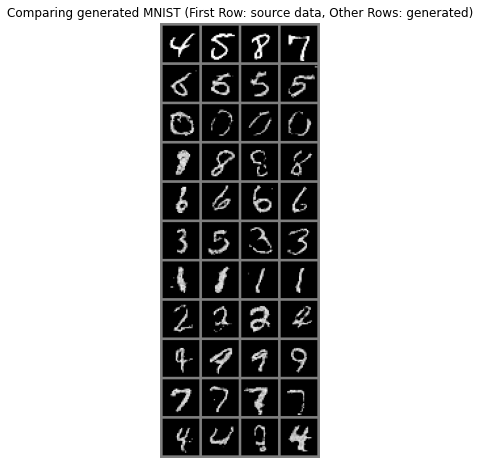

 test epoch: 130, loss: 0.24, accuracy: 60.59


In [60]:
rng, latent_rng, discrim_rng, gen_rng, first_print_rng, first_eval_rng  = jrandom.split(jrandom.PRNGKey(seed=42), num=6)

test_data = next(test_loader)
img_shape = jnp.shape(test_data)

# Size of noise input to Generator (does not include categorical input)
latent_dim = 64
latent_shape = jnp.shape(generate_latent_points(latent_rng, latent_dim, batch_size)[0])

discrim_state = create_train_discrim_state(discrim_rng,
                                           img_shape,
                                           0.0002)


gen_state = create_train_gen_state(gen_rng,
                                   latent_shape,
                                   0.0002)

# Adjust this to increase number of epochs trained
num_epochs = 130

print_exmp(first_print_rng, discrim_state, gen_state, latent_dim, test_data)
test_loss, test_accuracy = eval_model(first_eval_rng, discrim_state, gen_state, latent_dim, test_loader)
print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
    checkpoint_epoch(), test_loss, test_accuracy * 100))

loaded_checkpoint_epoch = checkpoint_epoch()
# only train if not loaded from save
if loaded_checkpoint_epoch <= num_epochs:
  for epoch in range(loaded_checkpoint_epoch+1, num_epochs + 1):
    rng, input_rng, eval_rng, print_rng = jax.random.split(rng, num=4)
    # Run an optimization step over a training batch
    discrim_state, gen_state = train_epoch(input_rng, discrim_state, gen_state, latent_dim, train_loader, epoch)
    save_model(discrim_state, gen_state, step=epoch)
    
    # Evaluate on the test set after each training epoch 
    test_loss, test_accuracy = eval_model(eval_rng, discrim_state, gen_state, latent_dim, test_loader)
    print_exmp(print_rng, discrim_state, gen_state, latent_dim, test_data)
    print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
        epoch, test_loss, test_accuracy * 100))

In [217]:
from google.colab import drive
drive.mount('/content/drive')

os.makedirs("/content/drive/MyDrive/Colab_Data/MNIST_GAN", exist_ok=True)
checkpoints.save_checkpoint(ckpt_dir="/content/drive/MyDrive/Colab_Data/MNIST_GAN",
                              target={'discrim_params': discrim_state.params,
                                      'gen_params': gen_state.params,
                                      'discrim_batch_stats': discrim_state.batch_stats,
                                      'gen_batch_stats': gen_state.batch_stats},
                              step=num_epochs,
                              overwrite=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab_Data/MNIST_GAN/checkpoint_130'